# Core Retrieval
Try to isolate the CLIP image encoder and the brain encoder to run retrieval

Calculate similarity score with all elements in the test set for subject 1
- Find the 10 images that best match a brain signal
- Find the 10 brain signals that best match an image

## What I understood from the code

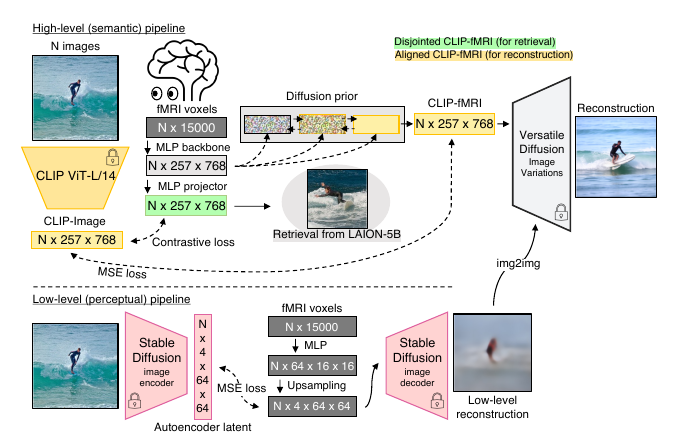

- I'll restrict myself to subject 1
    - Scotti et al only trained on 1, 2, 5, and 7 (the ones with data across all sessions)
    - They used the 1k shared images as test set
    - 2770 test samples were averaged over the 3 repetitions, resulting on 982 test samples
    - They refer to the test set as val, apparently. Did they use it for validation during training?
- I need to work with embeddings shaped $257\times 768$
    - Picked by Scotti et al to match the size at the last hidden layer of CLIP ViT/L-14
    - They should look like pictures. I'd love to plot them.
- I assume `Clipper` is the OpenAI CLIP encoder: 
    - For pre-trained models, it loads OpenAI's `"ViT-L/14"`
- I assume `OpenClipper` is the OpenCLIP encoder
    - It says `"THIS IS NOT WORKING CURRENTLY!"` on line 156, so maybe it's not fully functional x'D

## Global definitions

### Imports

In [ ]:
import os
import sys
import json
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import torch
import torch.nn as nn
from torchvision import transforms
from tqdm import tqdm
from datetime import datetime
import webdataset as wds
import PIL
import argparse

import pyvdirs.dirs as dirs
import pyvtools.image as vim

import utils
from models import Clipper, BrainNetwork
import my_utils as mutils

%load_ext autoreload
%autoreload 2

<frozen importlib._bootstrap>:241: RuntimeWarning: pyarrow.lib.Tensor size changed, may indicate binary incompatibility. Expected 64 from C header, got 80 from PyObject
<frozen importlib._bootstrap>:241: RuntimeWarning: pyarrow.lib.NativeFile size changed, may indicate binary incompatibility. Expected 96 from C header, got 104 from PyObject
<frozen importlib._bootstrap>:241: RuntimeWarning: pyarrow.lib.BufferedInputStream size changed, may indicate binary incompatibility. Expected 96 from C header, got 104 from PyObject
<frozen importlib._bootstrap>:241: RuntimeWarning: pyarrow.lib.BufferedOutputStream size changed, may indicate binary incompatibility. Expected 96 from C header, got 104 from PyObject
<frozen importlib._bootstrap>:241: RuntimeWarning: pyarrow.lib.CompressedInputStream size changed, may indicate binary incompatibility. Expected 96 from C header, got 104 from PyObject
<frozen importlib._bootstrap>:241: RuntimeWarning: pyarrow.lib.CompressedOutputStream size changed, may i

### Parameters

In [2]:
# Individual in the 1 to 8 range
subj = 1 

# Voxels per individual, sorted from Nr 1 to Nr 8
voxels_per_individual = [15724, 14278, 15226, 13153, 13039, 17907, 12682, 14386]
voxels_key = 'nsdgeneral.npy' # 1d inputs

# Path to where NSD data is stored
# data_path = "/fsx/proj-medarc/fmri/natural-scenes-dataset"
data_path = dirs.DATA_HOME
# Code is supposed to download dataset, if it's not found in there

# Path to metadata for all subjects
metadir = data_path

# Path to where the models are stored
# outdir = f'../train_logs/{autoencoder_name}'
outdir = dirs.MODELS_HOME

# Name of 257x768 model, used for everything except LAION-5B retrieval
model_name = "prior_257_final_subj01_bimixco_softclip_byol"

# Name of 1x768 model, used for LAION-5B retrieval
model_name2 = "prior_1x768_final_subj01_bimixco_softclip_byol"

# Name of the low-level pipeline's autoencoder
autoencoder_name = None

# Distribution factor between high and low-level pipelines
# 0 outputs the low-level image, 1 outputs the high-level image instead
img2img_strength = 1 # Not using img2img with the low-level pipeline on top of the high-level pipeline

# Network embedding parameters
out_dim = 257 * 768

# Retrieval test parameters
batch_size = 300 # same as used in mind_reader
test_batch_size = 300 # number of samples randomly picked (including the correct one) to assess accuracy
test_loops = 30 # number of times to go through the entire test set

# How many recons to output, to then automatically pick the best one (MindEye uses 16)
recons_per_sample = 1

### Definitions

In [3]:
num_voxels = voxels_per_individual[subj-1]
print("Subj", subj, "=> Num_voxels", num_voxels)

Subj 1 => Num_voxels 15724


In [4]:
# test_url = f"{data_path}/webdataset_avg_split/test/test_subj0{subj}_" + "{0..1}.tar"
test_url = f"{data_path}/test_subj0{subj}_" + "{0..1}.tar"
# meta_url = f"{data_path}/webdataset_avg_split/metadata_subj0{subj}.json"
meta_url = f"{data_path}/webdataset_avg_split_metadata_subj0{subj}.json"

In [5]:
metadata = json.load(open(meta_url))
num_train = metadata['totals']['train']
num_val = metadata['totals']['val']
num_test = metadata['totals']['test']

What is `num_train`? There are supposedly 24980 training samplesm not 8859. Mmm... It's close to 24980/3, but it's not exactly the same.

### General configuration

In [9]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Device:", device)

Device: cuda


In [10]:
seed = 42 # Random seed picked in the original code
utils.seed_everything(seed=seed)

### Test dataset

In [12]:
test_data = wds.WebDataset(test_url, resampled=True)\
    .decode("torch")\
    .rename(images="jpg;png", voxels=voxels_key, trial="trial.npy", coco="coco73k.npy", reps="num_uniques.npy")\
    .to_tuple("voxels", "images", "coco")\
    .batched(test_batch_size, partial=False)\
    .with_epoch(test_loops)

test_dataloader = torch.utils.data.DataLoader(test_data, batch_size=None, shuffle=False)

# Check that your data loader is working
for idx, (voxel, img_input, coco) in enumerate(test_dataloader):
    print("IDx", idx)
    print("Voxel shape", voxel.shape)
    print("Input image shape", img_input.shape)
    break
del idx, voxel, img_input, coco

/home/vale/anaconda3/envs/mindeye/lib/python3.10/site-packages/webdataset/compat.py:136: UserWarning: WebDataset(shardshuffle=...) is None; set explicitly to False or a number
  warnings.warn("WebDataset(shardshuffle=...) is None; set explicitly to False or a number")


IDx 0
Voxel shape torch.Size([300, 3, 15724])
Input image shape torch.Size([300, 3, 256, 256])


### Common neural networks

#### CLIP image encoder

In [13]:
clip_extractor = Clipper("ViT-L/14", hidden_state=True, norm_embs=True, device=device)

ViT-L/14 cuda


#### Brain encoder

In [14]:
voxel2clip_kwargs = dict(in_dim=num_voxels, out_dim=out_dim, use_projector=True, device=device)
voxel2clip = BrainNetwork(**voxel2clip_kwargs)
voxel2clip.requires_grad_(False)
voxel2clip.eval()

BrainNetwork(
  (lin0): Sequential(
    (0): Linear(in_features=15724, out_features=4096, bias=True)
    (1): LayerNorm((4096,), eps=1e-05, elementwise_affine=True)
    (2): GELU(approximate='none')
    (3): Dropout(p=0.5, inplace=False)
  )
  (mlp): ModuleList(
    (0-3): 4 x Sequential(
      (0): Linear(in_features=4096, out_features=4096, bias=True)
      (1): LayerNorm((4096,), eps=1e-05, elementwise_affine=True)
      (2): GELU(approximate='none')
      (3): Dropout(p=0.15, inplace=False)
    )
  )
  (lin1): Linear(in_features=4096, out_features=197376, bias=True)
  (projector): Sequential(
    (0): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
    (1): GELU(approximate='none')
    (2): Linear(in_features=768, out_features=2048, bias=True)
    (3): LayerNorm((2048,), eps=1e-05, elementwise_affine=True)
    (4): GELU(approximate='none')
    (5): Linear(in_features=2048, out_features=2048, bias=True)
    (6): LayerNorm((2048,), eps=1e-05, elementwise_affine=True)
    (7): G

In [15]:
ckpt_path = os.path.join(outdir, model_name, f'voxel2clip.pth')
# ckpt_path = os.path.join(outdir, model_name, f'last.pth')

checkpoint = torch.load(ckpt_path, map_location=device)
state_dict = checkpoint['model']
# state_dict = checkpoint['model_state_dict']
print("Checkpoint's number of epochs: ", checkpoint['epoch'])

Checkpoint's number of epochs:  239


In [16]:
p = next(voxel2clip.named_parameters())
p

('lin0.0.weight',
 Parameter containing:
 tensor([[-0.0005,  0.0054,  0.0052,  ...,  0.0009,  0.0078,  0.0016],
         [ 0.0027,  0.0060, -0.0027,  ..., -0.0002,  0.0026,  0.0041],
         [-0.0055,  0.0048,  0.0070,  ..., -0.0068, -0.0006, -0.0065],
         ...,
         [-0.0022,  0.0068, -0.0005,  ...,  0.0039,  0.0057, -0.0074],
         [-0.0053, -0.0028,  0.0025,  ...,  0.0059, -0.0076,  0.0079],
         [-0.0046,  0.0035, -0.0056,  ...,  0.0033,  0.0038,  0.0067]]))

In [17]:
voxel2clip.load_state_dict(state_dict, strict=False)
voxel2clip.eval().to(device)
del state_dict, checkpoint

In [18]:
p = next(voxel2clip.named_parameters())
p

('lin0.0.weight',
 Parameter containing:
 tensor([[ 0.0651, -0.0193, -0.0110,  ..., -0.0751, -0.0496, -0.0234],
         [-0.0425, -0.0803, -0.0196,  ..., -0.0571, -0.0532, -0.0319],
         [ 0.0376, -0.0324,  0.0556,  ...,  0.0490, -0.0190, -0.0379],
         ...,
         [ 0.0506, -0.0744,  0.0136,  ..., -0.0337,  0.0480, -0.0220],
         [ 0.0130, -0.0304,  0.0146,  ...,  0.0096, -0.0330, -0.0138],
         [ 0.0131, -0.0220, -0.0389,  ...,  0.0018,  0.0117, -0.0169]],
        device='cuda:0'))

## Test set retrieval

  0%|          | 0/30 [00:00<?, ?it/s]

Voxel's shape torch.Size([300, 3, 15724])
Image's shape torch.Size([300, 3, 256, 256])


/home/vale/anaconda3/envs/mindeye/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Averaged voxel's shape torch.Size([300, 15724])
Image embedding's shape torch.Size([300, 257, 768])
Brain embedding's shape torch.Size([300, 257, 768])


  3%|▎         | 1/30 [00:06<03:10,  6.58s/it]

Similarity matrix's shape torch.Size([300, 300])
Top-1 Accuracy per Brain Signal 96.66666984558105 %
Top-1 Accuracy per Image 93.33333373069763 %
Voxel's shape torch.Size([300, 3, 15724])
Image's shape torch.Size([300, 3, 256, 256])
Averaged voxel's shape torch.Size([300, 15724])
Image embedding's shape torch.Size([300, 257, 768])
Brain embedding's shape torch.Size([300, 257, 768])


  7%|▋         | 2/30 [00:12<02:52,  6.18s/it]

Similarity matrix's shape torch.Size([300, 300])
Top-1 Accuracy per Brain Signal 97.00000286102295 %
Top-1 Accuracy per Image 96.00000381469727 %


 10%|█         | 3/30 [00:18<02:42,  6.00s/it]

Top-1 Accuracy per Brain Signal 96.33333683013916 %
Top-1 Accuracy per Image 93.00000071525574 %


 13%|█▎        | 4/30 [00:24<02:33,  5.91s/it]

Top-1 Accuracy per Brain Signal 97.66666889190674 %
Top-1 Accuracy per Image 93.99999976158142 %


 17%|█▋        | 5/30 [00:29<02:26,  5.88s/it]

Top-1 Accuracy per Brain Signal 97.33333587646484 %
Top-1 Accuracy per Image 94.66667175292969 %


 20%|██        | 6/30 [00:35<02:20,  5.85s/it]

Top-1 Accuracy per Brain Signal 97.00000286102295 %
Top-1 Accuracy per Image 93.33333373069763 %


 23%|██▎       | 7/30 [00:41<02:14,  5.84s/it]

Top-1 Accuracy per Brain Signal 96.00000381469727 %
Top-1 Accuracy per Image 95.66667079925537 %


 27%|██▋       | 8/30 [00:47<02:08,  5.84s/it]

Top-1 Accuracy per Brain Signal 97.66666889190674 %
Top-1 Accuracy per Image 95.33333778381348 %


 30%|███       | 9/30 [00:53<02:02,  5.83s/it]

Top-1 Accuracy per Brain Signal 96.33333683013916 %
Top-1 Accuracy per Image 94.33333277702332 %


 33%|███▎      | 10/30 [00:59<01:57,  5.87s/it]

Top-1 Accuracy per Brain Signal 97.00000286102295 %
Top-1 Accuracy per Image 95.66667079925537 %


 37%|███▋      | 11/30 [01:04<01:50,  5.80s/it]

Top-1 Accuracy per Brain Signal 96.00000381469727 %
Top-1 Accuracy per Image 91.66666865348816 %


 40%|████      | 12/30 [01:10<01:42,  5.72s/it]

Top-1 Accuracy per Brain Signal 96.66666984558105 %
Top-1 Accuracy per Image 95.33333778381348 %


 43%|████▎     | 13/30 [01:16<01:38,  5.78s/it]

Top-1 Accuracy per Brain Signal 97.00000286102295 %
Top-1 Accuracy per Image 94.66667175292969 %


 47%|████▋     | 14/30 [01:22<01:32,  5.79s/it]

Top-1 Accuracy per Brain Signal 97.00000286102295 %
Top-1 Accuracy per Image 93.33333373069763 %


 50%|█████     | 15/30 [01:27<01:26,  5.79s/it]

Top-1 Accuracy per Brain Signal 96.66666984558105 %
Top-1 Accuracy per Image 94.66667175292969 %


 53%|█████▎    | 16/30 [01:33<01:20,  5.73s/it]

Top-1 Accuracy per Brain Signal 98.00000190734863 %
Top-1 Accuracy per Image 95.66667079925537 %


 57%|█████▋    | 17/30 [01:39<01:14,  5.72s/it]

Top-1 Accuracy per Brain Signal 96.66666984558105 %
Top-1 Accuracy per Image 94.33333277702332 %


 60%|██████    | 18/30 [01:44<01:08,  5.70s/it]

Top-1 Accuracy per Brain Signal 97.33333587646484 %
Top-1 Accuracy per Image 94.66667175292969 %


 63%|██████▎   | 19/30 [01:50<01:02,  5.68s/it]

Top-1 Accuracy per Brain Signal 96.66666984558105 %
Top-1 Accuracy per Image 94.33333277702332 %


 67%|██████▋   | 20/30 [01:56<00:56,  5.67s/it]

Top-1 Accuracy per Brain Signal 97.33333587646484 %
Top-1 Accuracy per Image 95.33333778381348 %


 70%|███████   | 21/30 [02:01<00:51,  5.70s/it]

Top-1 Accuracy per Brain Signal 98.00000190734863 %
Top-1 Accuracy per Image 95.66667079925537 %


 73%|███████▎  | 22/30 [02:07<00:45,  5.69s/it]

Top-1 Accuracy per Brain Signal 96.66666984558105 %
Top-1 Accuracy per Image 94.33333277702332 %


 77%|███████▋  | 23/30 [02:13<00:39,  5.71s/it]

Top-1 Accuracy per Brain Signal 97.33333587646484 %
Top-1 Accuracy per Image 94.33333277702332 %


 80%|████████  | 24/30 [02:18<00:34,  5.70s/it]

Top-1 Accuracy per Brain Signal 97.00000286102295 %
Top-1 Accuracy per Image 93.33333373069763 %


 83%|████████▎ | 25/30 [02:24<00:28,  5.75s/it]

Top-1 Accuracy per Brain Signal 96.66666984558105 %
Top-1 Accuracy per Image 95.00000476837158 %


 87%|████████▋ | 26/30 [02:30<00:23,  5.81s/it]

Top-1 Accuracy per Brain Signal 96.33333683013916 %
Top-1 Accuracy per Image 93.66666674613953 %


 90%|█████████ | 27/30 [02:36<00:17,  5.76s/it]

Top-1 Accuracy per Brain Signal 96.33333683013916 %
Top-1 Accuracy per Image 94.66667175292969 %


 93%|█████████▎| 28/30 [02:41<00:11,  5.73s/it]

Top-1 Accuracy per Brain Signal 96.66666984558105 %
Top-1 Accuracy per Image 95.00000476837158 %


 97%|█████████▋| 29/30 [02:47<00:05,  5.68s/it]

Top-1 Accuracy per Brain Signal 96.66666984558105 %
Top-1 Accuracy per Image 93.33333373069763 %


100%|██████████| 30/30 [02:53<00:00,  5.78s/it]

Top-1 Accuracy per Brain Signal 97.00000286102295 %
Top-1 Accuracy per Image 93.33333373069763 %


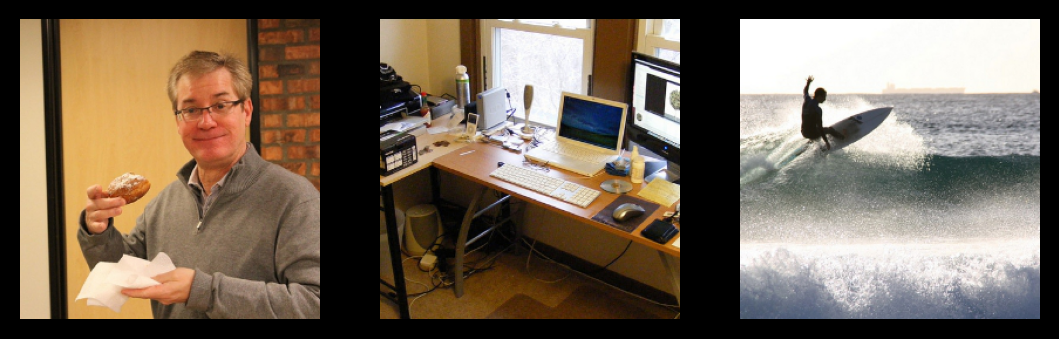

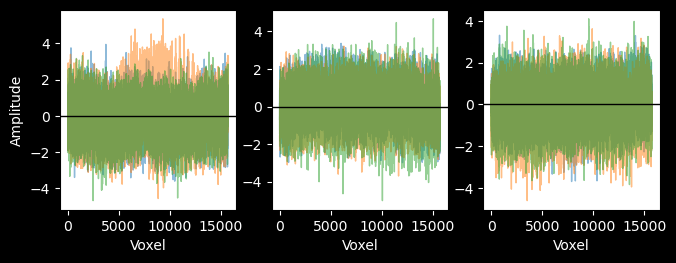

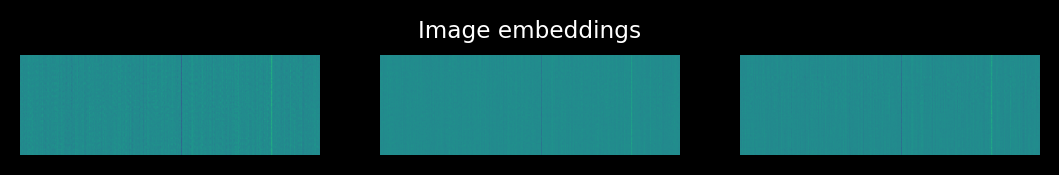

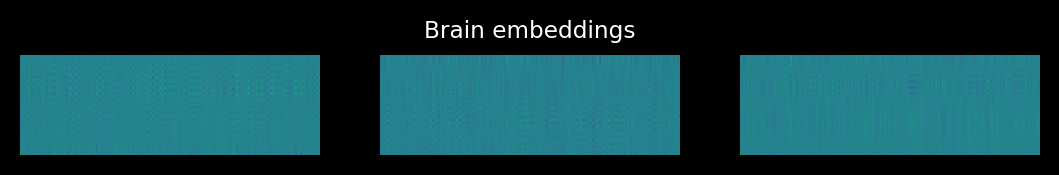

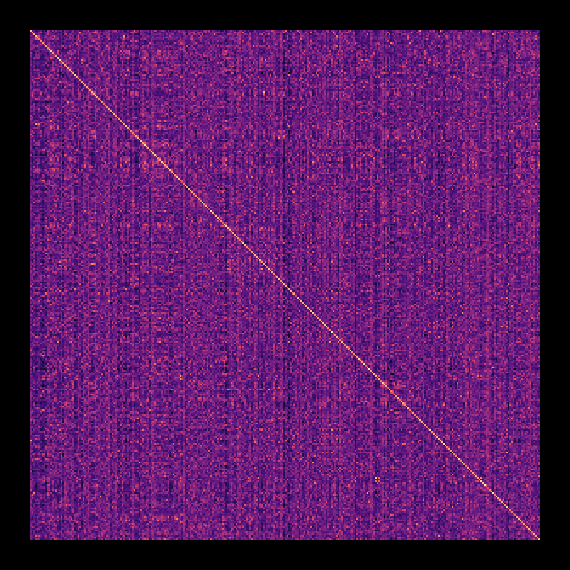

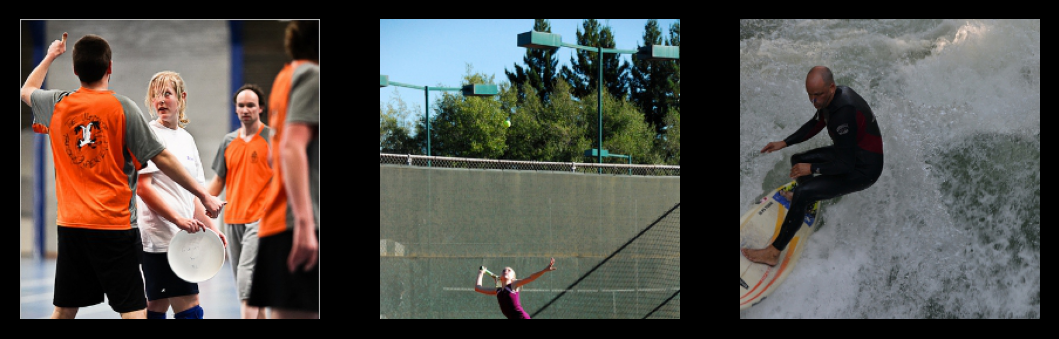

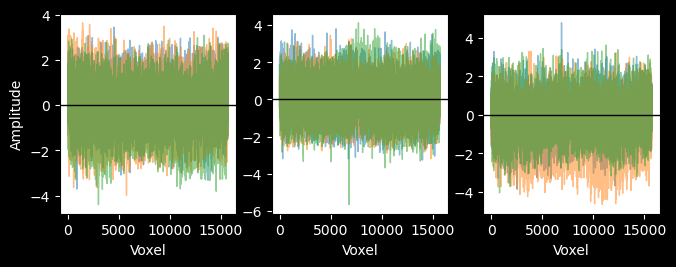

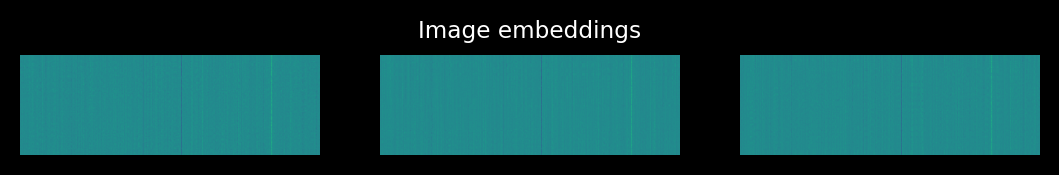

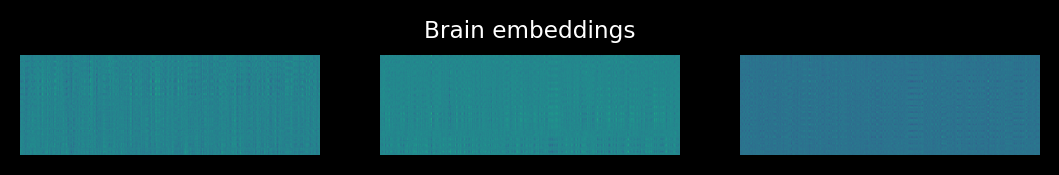

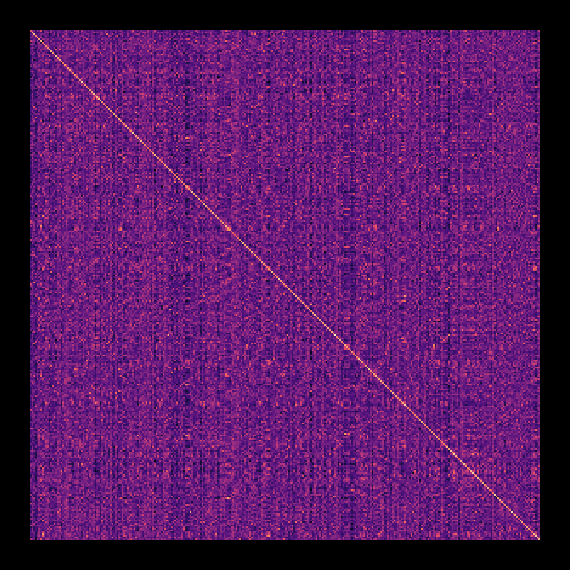

In [24]:
percents_correct_forwards, percents_correct_backwards = [], []

with torch.no_grad():
    k = 0
    for idx, (voxel, img, coco) in enumerate(tqdm(test_dataloader, total=test_loops)):

        if idx<3 and k<2:
            print("Voxel's shape", voxel.shape)
            print("Image's shape", img.shape)
            vim.plot_images(*img[:3].cpu().detach().numpy().transpose(0,2,3,1))
            mutils.plot_brain_signals(*voxel.cpu().detach().numpy()[:3])

        voxel = torch.mean(voxel, axis=1).to(device) # average across repetitions
        # voxel = voxel[:,np.random.randint(3)].to(device) # random one of the single-trial samples

        emb_img = clip_extractor.embed_image(img.to(device)).float() # CLIP-Image
        
        _, emb_brain = voxel2clip(voxel.float()) # CLIP-Brain
        
        if idx<3 and k<2:
            print("Averaged voxel's shape", voxel.shape)
            print("Image embedding's shape", emb_img.shape)
            print("Brain embedding's shape", emb_brain.shape)
            vim.plot_images(*emb_img[:3].cpu().detach().numpy(), labels=["","Image embeddings",""])
            vim.plot_images(*emb_brain[:3].cpu().detach().numpy(), labels=["","Brain embeddings",""])
        
        # Flatten if necessary
        emb_img = emb_img.reshape(len(emb_img),-1)
        emb_brain = emb_brain.reshape(len(emb_brain),-1)
        
        # L2 normalization
        emb_img = nn.functional.normalize(emb_img, dim=-1)
        emb_brain = nn.functional.normalize(emb_brain, dim=-1)
        
        labels = torch.arange(len(emb_img)).to(device)
        similarity = utils.batchwise_cosine_similarity(emb_brain, emb_img)  # Brain, CLIP

        # similarity_backwards = utils.batchwise_cosine_similarity(emb_img, emb_brain)  # clip, brain
        # similarity_forwards = utils.batchwise_cosine_similarity(emb_brain, emb_img)  # brain, clip
        # print(np.any((similarity_backwards.cpu().detach().numpy().T != similarity_forwards.cpu().detach().numpy()).flatten()))

        if idx<3 and k<2:
            print("Similarity matrix's shape", similarity.shape)
            vim.plot_image(similarity.cpu().detach().numpy(), 
                            dpi=300, interpolation="none", colormap="magma")
        
        top1_forwards = utils.topk(similarity, labels, k=1).item()
        top1_backwards = utils.topk(torch.transpose(similarity, 0, 1), labels, k=1).item()
        print("Top-1 Accuracy per Brain Signal", top1_forwards*100, r"%")
        print("Top-1 Accuracy per Image", top1_backwards*100, r"%")
        
        percents_correct_forwards.append(top1_forwards)
        percents_correct_backwards.append(top1_backwards)
            
        k += 1
        # break

In [25]:
percent_correct_fwd = np.mean(percents_correct_forwards)
fwd_sd = np.std(percents_correct_forwards) / np.sqrt(len(percents_correct_forwards))
fwd_ci = stats.norm.interval(0.95, loc=percent_correct_fwd, scale=fwd_sd)

percent_correct_bwd = np.mean(percents_correct_backwards)
bwd_sd = np.std(percents_correct_backwards) / np.sqrt(len(percents_correct_backwards))
bwd_ci = stats.norm.interval(0.95, loc=percent_correct_bwd, scale=bwd_sd)

print(f"fwd percent_correct: {percent_correct_fwd:.4f} 95% CI: [{fwd_ci[0]:.4f},{fwd_ci[1]:.4f}]")
print(f"bwd percent_correct: {percent_correct_bwd:.4f} 95% CI: [{bwd_ci[0]:.4f},{bwd_ci[1]:.4f}]")

fwd percent_correct: 0.9690 95% CI: [0.9672,0.9708]
bwd percent_correct: 0.9440 95% CI: [0.9404,0.9476]
